In [55]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [56]:
import tensorflow as tf
#tf.random.set_seed(1)
#gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.3)

import re
import csv
import cv2
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
import scipy.optimize
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.patches as Patches
from shapely.geometry import Polygon
import random
from tensorflow.keras.layers import UpSampling2D,concatenate,Conv2D,BatchNormalization,Activation,Lambda
from tensorflow.keras.models import Model
from keras.models import load_model
from tensorflow.keras.applications import ResNet50,ResNet50V2
from tqdm import tqdm
import pathlib
import multiprocessing
import scipy.io as sio
try:
    import queue
except ImportError:
    import Queue as queue

In [57]:
# print(os.getcwd() + '/Robust_Reading/ICDAR_2015/')

# Training on ICDAR 2015 Data

In [58]:
# def creating_dataframe(dir_path,train_test):
#     a =[]
#     for i in os.listdir(dir_path):
#         if i == train_test or i == train_test+'_gt':
#             dir_path1 = dir_path+ i
#             dir_path2= pathlib.Path(dir_path1)
#             dir_path3=dir_path2.glob('*.*')
#             dir_path3 = [str(j) for j in dir_path3]
#             a.append(dir_path3)
#     data_frame=pd.DataFrame(list(zip(a[0],a[1])),columns=['images', 'ground_truth'])
#     data_frame['images']=sorted(data_frame['images'])
#     data_frame['ground_truth']=sorted(data_frame['ground_truth'])
#     return data_frame
    
dir_path = "/home/cloudcraftz/subhasish/RBOX Geometry/ICDAR_2015/"
## train
a =[]
for i in os.listdir(dir_path):
    if i == 'train' or i == 'train'+'_gt':
        dir_path1 = dir_path+ i
        dir_path2= pathlib.Path(dir_path1)
        dir_path3=dir_path2.glob('*.*')
        dir_path3 = [str(j) for j in dir_path3]
        a.append(dir_path3)
train_data=pd.DataFrame(list(zip(a[0],a[1])),columns=['images', 'ground_truth'])
train_data['images']=sorted(train_data['images'])
train_data['ground_truth']=sorted(train_data['ground_truth'])

##test
a =[]
for i in os.listdir(dir_path):
    if i == 'test' or i == 'test'+'_gt':
        dir_path1 = dir_path+ i
        dir_path2= pathlib.Path(dir_path1)
        dir_path3=dir_path2.glob('*.*')
        dir_path3 = [str(j) for j in dir_path3]
        a.append(dir_path3)
test_data=pd.DataFrame(list(zip(a[1],a[0])),columns=['images', 'ground_truth'])
test_data['images']=sorted(test_data['images'])
test_data['ground_truth']=sorted(test_data['ground_truth'])


In [59]:
test_data.images[0]

'/home/cloudcraftz/subhasish/RBOX Geometry/ICDAR_2015/test/img_1.jpg'

In [60]:
%ls

1.png                scene_Text_detect_colab_final.ipynb
detection_resnet50/  scene_Text_detect.ipynb
ICDAR_2015/          test.ipynb


In [61]:
# train_data = creating_dataframe("/Users/subhasish/Documents/ISI_CVPR_BACKUP/Robust_Reading/ICDAR_2015/","train")
# test_data = creating_dataframe("/Users/subhasish/Documents/ISI_CVPR_BACKUP/Robust_Reading/ICDAR_2015/","test")


In [62]:
print(len(os.listdir(dir_path+'train')))

1000


In [63]:
train_data.images[0]

'/home/cloudcraftz/subhasish/RBOX Geometry/ICDAR_2015/train/img_1.jpg'

In [64]:
test_data.images[0]

'/home/cloudcraftz/subhasish/RBOX Geometry/ICDAR_2015/test/img_1.jpg'

In [65]:
print(len(os.listdir(dir_path+'test')))

500


In [66]:
test_data.head()

,images,ground_truth
0,/home/cloudcraftz/subhasish/RBOX Geometry/ICDA...,/home/cloudcraftz/subhasish/RBOX Geometry/ICDA...
1,/home/cloudcraftz/subhasish/RBOX Geometry/ICDA...,/home/cloudcraftz/subhasish/RBOX Geometry/ICDA...
2,/home/cloudcraftz/subhasish/RBOX Geometry/ICDA...,/home/cloudcraftz/subhasish/RBOX Geometry/ICDA...
3,/home/cloudcraftz/subhasish/RBOX Geometry/ICDA...,/home/cloudcraftz/subhasish/RBOX Geometry/ICDA...
4,/home/cloudcraftz/subhasish/RBOX Geometry/ICDA...,/home/cloudcraftz/subhasish/RBOX Geometry/ICDA...


In [67]:
# def text_cod(df):
#     co_ordinates = []
#     texts = []
#     for path in df['ground_truth']:
#         li = []
#         f = open(str(path), "r",encoding='utf-8-sig')
#     for x in f:
#         li.append(x.split(','))
#         ji = []
#     for i in li:
#         a = i[-1]
#         a = re.sub(r"[\n\t\-\\\/]","",a)
#         a = a.lower() 
#         ji.append(a)  
#     az = li
#     for i in az:
#         i.remove(i[-1])

#     co_ordinates.append(az)
#     texts.append(ji)
#     return texts,co_ordinates

#adding the Co-ordinates and text of the images to the DataFrame


def text_coordinates(df):
    
    co_ordinates = []
    texts = []
    
    for path in df['ground_truth']:
        cord_list = []
        with open(path, encoding="utf8", errors='ignore') as f:
        #f = open(path,'r+',encoding  = 'utf-8-sig')
            for x in f:
                cord_list.append(x.split(','))
            text_list = []
            for i in cord_list:
                word = i[-1]
                word = re.sub(r"[\n\t\-\\\/]","",word)
                word = word.lower()
                text_list.append(word)
            final_cord_list = cord_list
            for i in final_cord_list:
                i.remove(i[-1])
                
            co_ordinates.append(final_cord_list)
            texts.append(text_list)
        
    return texts,co_ordinates

In [68]:
texts,co_ordinates = text_coordinates(test_data)
test_data['texts']=texts
test_data['coordinates'] =co_ordinates

In [69]:
test_data.head()

,images,ground_truth,texts,coordinates
0,/home/cloudcraftz/subhasish/RBOX Geometry/ICDA...,/home/cloudcraftz/subhasish/RBOX Geometry/ICDA...,"[###, ###, ###, ###, ###, ###, ###, ###]","[[933, 255, 954, 255, 956, 277, 936, 277], [17..."
1,/home/cloudcraftz/subhasish/RBOX Geometry/ICDA...,/home/cloudcraftz/subhasish/RBOX Geometry/ICDA...,"[please, lower, your, volume, when, you, pass,...","[[27, 17, 103, 22, 106, 47, 30, 45], [107, 20,..."
2,/home/cloudcraftz/subhasish/RBOX Geometry/ICDA...,/home/cloudcraftz/subhasish/RBOX Geometry/ICDA...,"[###, diverse, tastes, ###, flavours, the, ref...","[[454, 115, 477, 115, 474, 130, 457, 132], [47..."
3,/home/cloudcraftz/subhasish/RBOX Geometry/ICDA...,/home/cloudcraftz/subhasish/RBOX Geometry/ICDA...,"[sale, marc, ###]","[[831, 115, 1003, 72, 1012, 171, 835, 195], [4..."
4,/home/cloudcraftz/subhasish/RBOX Geometry/ICDA...,/home/cloudcraftz/subhasish/RBOX Geometry/ICDA...,"[st.marc, cafe, ###, ###]","[[615, 246, 698, 251, 694, 281, 615, 272], [69..."


In [70]:
texts,co_ordinates = text_coordinates(train_data)
train_data['texts']=co_ordinates
train_data['coordinates'] =texts

In [71]:
train_data.head()

,images,ground_truth,texts,coordinates
0,/home/cloudcraftz/subhasish/RBOX Geometry/ICDA...,/home/cloudcraftz/subhasish/RBOX Geometry/ICDA...,"[[﻿377, 117, 463, 117, 465, 130, 378, 130], [4...","[genaxis theatre, [06], ###, 6203, carpark, ##..."
1,/home/cloudcraftz/subhasish/RBOX Geometry/ICDA...,/home/cloudcraftz/subhasish/RBOX Geometry/ICDA...,"[[﻿261, 138, 284, 140, 279, 158, 260, 158], [2...","[###, harbourfront, cc22, bua, ###, ###, ###, ..."
2,/home/cloudcraftz/subhasish/RBOX Geometry/ICDA...,/home/cloudcraftz/subhasish/RBOX Geometry/ICDA...,"[[﻿645, 19, 686, 13, 692, 43, 651, 48], [689, ...","[way, out, ###, line, platform, ###, ###, ###]"
3,/home/cloudcraftz/subhasish/RBOX Geometry/ICDA...,/home/cloudcraftz/subhasish/RBOX Geometry/ICDA...,"[[﻿486, 216, 554, 211, 558, 243, 489, 248], [1...","[###, ###, ###, ###]"
4,/home/cloudcraftz/subhasish/RBOX Geometry/ICDA...,/home/cloudcraftz/subhasish/RBOX Geometry/ICDA...,"[[﻿899, 214, 928, 213, 928, 241, 900, 242], [9...","[care, sticker, for, ###, more, ###, ###, ###,..."


In [72]:
test_data.images[0]

'/home/cloudcraftz/subhasish/RBOX Geometry/ICDAR_2015/test/img_1.jpg'

In [73]:
# train_data['images'][48]
# train_data=train_data.drop(48)
# train_data.shape

In [74]:
train_data.ground_truth[0]

'/home/cloudcraftz/subhasish/RBOX Geometry/ICDAR_2015/train_gt/gt_img_1.txt'

In [75]:
#vocabulary creation
l=list(train_data['ground_truth'])
CLASSES=[]
for i in tqdm(l):
    file=open(i)
    for line in file:
        line=line.replace('\n','')
        a=line.split(",")[-1]
        if a!='':
            CLASSES.append(a)
NUM_CLASSES=len(list(set(CLASSES)))

100%|██████████| 1000/1000 [00:00<00:00, 23705.74it/s]


In [76]:
# NUM_CLASSES=2683

In [77]:
NUM_CLASSES

2683

In [78]:
#vocabulary creation
l=list(train_data['ground_truth'])
CLASSES=[]
for i in tqdm(l):
    file=open(i)
    for line in file:
        line=line.replace('\n','')
        a=line.split(",")[-1]
        if a!='':
            CLASSES.append(a)
NUM_CLASSES=len(list(set(CLASSES))) 

100%|██████████| 1000/1000 [00:00<00:00, 26124.60it/s]


In [79]:
print(NUM_CLASSES)

2683


# TEXT DETECTION : EAST 

In [80]:
def load_annoataion(p):
    '''
    load polygon coordinate and text from the text file for corresponding image
    here p is name of image file whose cooresponding annotation we want 
    '''
    text_polys = []
    text_tags = []
    if not os.path.exists(p):
        return np.array(text_polys, dtype=np.float32), np.array(text_tags, dtype=np.int32)
    with open(p, 'r') as f:
        reader = csv.reader(f)
        for line in reader:
            label = line[-1].replace(' ','')
            line = [i.strip('\ufeff').strip('\xef\xbb\xbf') for i in line]

            x1, y1, x2, y2, x3, y3, x4, y4 = list(map(float, line[:8]))
            text_polys.append([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])
            
            if label == '###':
                text_tags.append(None)
            else:
                text_tags.append(label)

        return np.array(text_polys, dtype=np.float32), text_tags

In [81]:
# This Function is used to calculate AREA of polygon
def polygon_area(poly):
    '''
    compute area of a polygon
    '''
    edge = [
        (poly[1][0] - poly[0][0]) * (poly[1][1] + poly[0][1]),
        (poly[2][0] - poly[1][0]) * (poly[2][1] + poly[1][1]),
        (poly[3][0] - poly[2][0]) * (poly[3][1] + poly[2][1]),
        (poly[0][0] - poly[3][0]) * (poly[0][1] + poly[3][1])
    ]
    return np.sum(edge)/2.

In [82]:
def check_and_validate_polys(polys, tags, xxx_todo_changeme):
    '''
    check so that the text poly is in the same direction,
    and also filter some invalid polygons
    '''
    (h, w) = xxx_todo_changeme
    if polys.shape[0] == 0:
        return polys
    polys[:, :, 0] = np.clip(polys[:, :, 0], 0, w-1)
    polys[:, :, 1] = np.clip(polys[:, :, 1], 0, h-1)

    validated_polys = []
    validated_tags = []
    for poly, tag in zip(polys, tags):
        p_area = polygon_area(poly)
        if abs(p_area) < 1:
            # print poly
            print('invalid poly')
            continue
        if p_area > 0:
            print('poly in wrong direction')
            poly = poly[(0, 3, 2, 1), :]
        validated_polys.append(poly)
        validated_tags.append(tag)
    return np.array(validated_polys),np.array(validated_tags)

In [83]:
#This function is implementation of Polygon Shrinkage Algorithm 
def shrink_poly(poly, r):
    '''
    fit a poly inside the origin poly
    used for generate the score map
    '''
    # shrink ratio
    R = 0.3
    # find the longer pair
    if np.linalg.norm(poly[0] - poly[1]) + np.linalg.norm(poly[2] - poly[3]) > \
                    np.linalg.norm(poly[0] - poly[3]) + np.linalg.norm(poly[1] - poly[2]):
        # first move (p0, p1), (p2, p3), then (p0, p3), (p1, p2)
        ## p0, p1
        theta = np.arctan2((poly[1][1] - poly[0][1]), (poly[1][0] - poly[0][0]))
        poly[0][0] += R * r[0] * np.cos(theta)
        poly[0][1] += R * r[0] * np.sin(theta)
        poly[1][0] -= R * r[1] * np.cos(theta)
        poly[1][1] -= R * r[1] * np.sin(theta)
        ## p2, p3
        theta = np.arctan2((poly[2][1] - poly[3][1]), (poly[2][0] - poly[3][0]))
        poly[3][0] += R * r[3] * np.cos(theta)
        poly[3][1] += R * r[3] * np.sin(theta)
        poly[2][0] -= R * r[2] * np.cos(theta)
        poly[2][1] -= R * r[2] * np.sin(theta)
        ## p0, p3
        theta = np.arctan2((poly[3][0] - poly[0][0]), (poly[3][1] - poly[0][1]))
        poly[0][0] += R * r[0] * np.sin(theta)
        poly[0][1] += R * r[0] * np.cos(theta)
        poly[3][0] -= R * r[3] * np.sin(theta)
        poly[3][1] -= R * r[3] * np.cos(theta)
        ## p1, p2
        theta = np.arctan2((poly[2][0] - poly[1][0]), (poly[2][1] - poly[1][1]))
        poly[1][0] += R * r[1] * np.sin(theta)
        poly[1][1] += R * r[1] * np.cos(theta)
        poly[2][0] -= R * r[2] * np.sin(theta)
        poly[2][1] -= R * r[2] * np.cos(theta)
    else:
        ## p0, p3
        # print poly
        theta = np.arctan2((poly[3][0] - poly[0][0]), (poly[3][1] - poly[0][1]))
        poly[0][0] += R * r[0] * np.sin(theta)
        poly[0][1] += R * r[0] * np.cos(theta)
        poly[3][0] -= R * r[3] * np.sin(theta)
        poly[3][1] -= R * r[3] * np.cos(theta)
        ## p1, p2
        theta = np.arctan2((poly[2][0] - poly[1][0]), (poly[2][1] - poly[1][1]))
        poly[1][0] += R * r[1] * np.sin(theta)
        poly[1][1] += R * r[1] * np.cos(theta)
        poly[2][0] -= R * r[2] * np.sin(theta)
        poly[2][1] -= R * r[2] * np.cos(theta)
        ## p0, p1
        theta = np.arctan2((poly[1][1] - poly[0][1]), (poly[1][0] - poly[0][0]))
        poly[0][0] += R * r[0] * np.cos(theta)
        poly[0][1] += R * r[0] * np.sin(theta)
        poly[1][0] -= R * r[1] * np.cos(theta)
        poly[1][1] -= R * r[1] * np.sin(theta)
        ## p2, p3
        theta = np.arctan2((poly[2][1] - poly[3][1]), (poly[2][0] - poly[3][0]))
        poly[3][0] += R * r[3] * np.cos(theta)
        poly[3][1] += R * r[3] * np.sin(theta)
        poly[2][0] -= R * r[2] * np.cos(theta)
        poly[2][1] -= R * r[2] * np.sin(theta)
    return poly

In [84]:
#Compute distance between p1-p2 and p3
def point_dist_to_line(p1, p2, p3):
    '''compute the distance from p3 to p1-p2'''
    return np.linalg.norm(np.cross(p2 - p1, p1 - p3)) / np.linalg.norm(p2 - p1)

In [85]:
def fit_line(p1, p2):
    '''fit a line ax+by+c = 0'''
    if p1[0] == p1[1]:
        return [1., 0., -p1[0]]
    else:
        [k, b] = np.polyfit(p1, p2, deg=1)
        return [k, -1., b]

In [86]:
def line_cross_point(line1, line2):
    '''line1 0= ax+by+c, compute the cross point of line1 and line2'''
    if line1[0] != 0 and line1[0] == line2[0]:
        print('Cross point does not exist')
        return None
    if line1[0] == 0 and line2[0] == 0:
        print('Cross point does not exist')
        return None
    if line1[1] == 0:
        x = -line1[2]
        y = line2[0] * x + line2[2]
    elif line2[1] == 0:
        x = -line2[2]
        y = line1[0] * x + line1[2]
    else:
        k1, _, b1 = line1
        k2, _, b2 = line2
        x = -(b1-b2)/(k1-k2)
        y = k1*x + b1
    return np.array([x, y], dtype=np.float32)

In [87]:
def line_verticle(line, point):
    '''get the verticle line from line across point'''
    if line[1] == 0:
        verticle = [0, -1, point[1]]
    else:
        if line[0] == 0:
            verticle = [1, 0, -point[0]]
        else:
            verticle = [-1./line[0], -1, point[1] - (-1/line[0] * point[0])]
    return verticle

In [88]:
# Convert a parallelogram to rectangle
def rectangle_from_parallelogram(poly):
    '''
    fit a rectangle from a parallelogram
    '''
    p0, p1, p2, p3 = poly
    angle_p0 = np.arccos(np.dot(p1-p0, p3-p0)/(np.linalg.norm(p0-p1) * np.linalg.norm(p3-p0)))
    if angle_p0 < 0.5 * np.pi:
        if np.linalg.norm(p0 - p1) > np.linalg.norm(p0-p3):
            # p0 and p2
            ## p0
            p2p3 = fit_line([p2[0], p3[0]], [p2[1], p3[1]])
            p2p3_verticle = line_verticle(p2p3, p0)

            new_p3 = line_cross_point(p2p3, p2p3_verticle)
            ## p2
            p0p1 = fit_line([p0[0], p1[0]], [p0[1], p1[1]])
            p0p1_verticle = line_verticle(p0p1, p2)

            new_p1 = line_cross_point(p0p1, p0p1_verticle)
            return np.array([p0, new_p1, p2, new_p3], dtype=np.float32)
        else:
            p1p2 = fit_line([p1[0], p2[0]], [p1[1], p2[1]])
            p1p2_verticle = line_verticle(p1p2, p0)

            new_p1 = line_cross_point(p1p2, p1p2_verticle)
            p0p3 = fit_line([p0[0], p3[0]], [p0[1], p3[1]])
            p0p3_verticle = line_verticle(p0p3, p2)

            new_p3 = line_cross_point(p0p3, p0p3_verticle)
            return np.array([p0, new_p1, p2, new_p3], dtype=np.float32)
    else:
        if np.linalg.norm(p0-p1) > np.linalg.norm(p0-p3):
            # p1 and p3
            ## p1
            p2p3 = fit_line([p2[0], p3[0]], [p2[1], p3[1]])
            p2p3_verticle = line_verticle(p2p3, p1)

            new_p2 = line_cross_point(p2p3, p2p3_verticle)
            ## p3
            p0p1 = fit_line([p0[0], p1[0]], [p0[1], p1[1]])
            p0p1_verticle = line_verticle(p0p1, p3)

            new_p0 = line_cross_point(p0p1, p0p1_verticle)
            return np.array([new_p0, p1, new_p2, p3], dtype=np.float32)
        else:
            p0p3 = fit_line([p0[0], p3[0]], [p0[1], p3[1]])
            p0p3_verticle = line_verticle(p0p3, p1)

            new_p0 = line_cross_point(p0p3, p0p3_verticle)
            p1p2 = fit_line([p1[0], p2[0]], [p1[1], p2[1]])
            p1p2_verticle = line_verticle(p1p2, p3)

            new_p2 = line_cross_point(p1p2, p1p2_verticle)
            return np.array([new_p0, p1, new_p2, p3], dtype=np.float32)

In [89]:
def sort_rectangle(poly):
    '''sort the four coordinates of the polygon, points in poly should be sorted clockwise'''
    # First find the lowest point
    p_lowest = np.argmax(poly[:, 1])
    if np.count_nonzero(poly[:, 1] == poly[p_lowest, 1]) == 2:
        # if the bottom line is parallel to x-axis, then p0 must be the upper-left corner
        p0_index = np.argmin(np.sum(poly, axis=1))
        p1_index = (p0_index + 1) % 4
        p2_index = (p0_index + 2) % 4
        p3_index = (p0_index + 3) % 4
        return poly[[p0_index, p1_index, p2_index, p3_index]], 0.
    else:
        # find the point that sits right to the lowest point
        p_lowest_right = (p_lowest - 1) % 4
        p_lowest_left = (p_lowest + 1) % 4
        angle = np.arctan(-(poly[p_lowest][1] - poly[p_lowest_right][1])/(poly[p_lowest][0] - poly[p_lowest_right][0]))
        # assert angle > 0
        if angle <= 0:
            print(angle, poly[p_lowest], poly[p_lowest_right])
        if angle/np.pi * 180 > 45:
            #this point is p2
            p2_index = p_lowest
            p1_index = (p2_index - 1) % 4
            p0_index = (p2_index - 2) % 4
            p3_index = (p2_index + 1) % 4
            return poly[[p0_index, p1_index, p2_index, p3_index]], -(np.pi/2 - angle)
        else:
            # this point is p3
            p3_index = p_lowest
            p0_index = (p3_index + 1) % 4
            p1_index = (p3_index + 2) % 4
            p2_index = (p3_index + 3) % 4
            return poly[[p0_index, p1_index, p2_index, p3_index]], angle

In [90]:
def restore_rectangle_rbox(origin, geometry):
    ''' Resotre rectangle tbox'''
    d = geometry[:, :4]
    angle = geometry[:, 4]
    # for angle > 0
    origin_0 = origin[angle >= 0]
    d_0 = d[angle >= 0]
    angle_0 = angle[angle >= 0]
    if origin_0.shape[0] > 0:
        p = np.array([np.zeros(d_0.shape[0]), -d_0[:, 0] - d_0[:, 2],
                      d_0[:, 1] + d_0[:, 3], -d_0[:, 0] - d_0[:, 2],
                      d_0[:, 1] + d_0[:, 3], np.zeros(d_0.shape[0]),
                      np.zeros(d_0.shape[0]), np.zeros(d_0.shape[0]),
                      d_0[:, 3], -d_0[:, 2]])
        p = p.transpose((1, 0)).reshape((-1, 5, 2))  # N*5*2

        rotate_matrix_x = np.array([np.cos(angle_0), np.sin(angle_0)]).transpose((1, 0))
        rotate_matrix_x = np.repeat(rotate_matrix_x, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))  # N*5*2

        rotate_matrix_y = np.array([-np.sin(angle_0), np.cos(angle_0)]).transpose((1, 0))
        rotate_matrix_y = np.repeat(rotate_matrix_y, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))

        p_rotate_x = np.sum(rotate_matrix_x * p, axis=2)[:, :, np.newaxis]  # N*5*1
        p_rotate_y = np.sum(rotate_matrix_y * p, axis=2)[:, :, np.newaxis]  # N*5*1

        p_rotate = np.concatenate([p_rotate_x, p_rotate_y], axis=2)  # N*5*2

        p3_in_origin = origin_0 - p_rotate[:, 4, :]
        new_p0 = p_rotate[:, 0, :] + p3_in_origin  # N*2
        new_p1 = p_rotate[:, 1, :] + p3_in_origin
        new_p2 = p_rotate[:, 2, :] + p3_in_origin
        new_p3 = p_rotate[:, 3, :] + p3_in_origin

        new_p_0 = np.concatenate([new_p0[:, np.newaxis, :], new_p1[:, np.newaxis, :],
                                  new_p2[:, np.newaxis, :], new_p3[:, np.newaxis, :]], axis=1)  # N*4*2
    else:
        new_p_0 = np.zeros((0, 4, 2))
    # for angle < 0
    origin_1 = origin[angle < 0]
    d_1 = d[angle < 0]
    angle_1 = angle[angle < 0]
    if origin_1.shape[0] > 0:
        p = np.array([-d_1[:, 1] - d_1[:, 3], -d_1[:, 0] - d_1[:, 2],
                      np.zeros(d_1.shape[0]), -d_1[:, 0] - d_1[:, 2],
                      np.zeros(d_1.shape[0]), np.zeros(d_1.shape[0]),
                      -d_1[:, 1] - d_1[:, 3], np.zeros(d_1.shape[0]),
                      -d_1[:, 1], -d_1[:, 2]])
        p = p.transpose((1, 0)).reshape((-1, 5, 2))  # N*5*2

        rotate_matrix_x = np.array([np.cos(-angle_1), -np.sin(-angle_1)]).transpose((1, 0))
        rotate_matrix_x = np.repeat(rotate_matrix_x, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))  # N*5*2

        rotate_matrix_y = np.array([np.sin(-angle_1), np.cos(-angle_1)]).transpose((1, 0))
        rotate_matrix_y = np.repeat(rotate_matrix_y, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))

        p_rotate_x = np.sum(rotate_matrix_x * p, axis=2)[:, :, np.newaxis]  # N*5*1
        p_rotate_y = np.sum(rotate_matrix_y * p, axis=2)[:, :, np.newaxis]  # N*5*1

        p_rotate = np.concatenate([p_rotate_x, p_rotate_y], axis=2)  # N*5*2

        p3_in_origin = origin_1 - p_rotate[:, 4, :]
        new_p0 = p_rotate[:, 0, :] + p3_in_origin  # N*2
        new_p1 = p_rotate[:, 1, :] + p3_in_origin
        new_p2 = p_rotate[:, 2, :] + p3_in_origin
        new_p3 = p_rotate[:, 3, :] + p3_in_origin

        new_p_1 = np.concatenate([new_p0[:, np.newaxis, :], new_p1[:, np.newaxis, :],
                                  new_p2[:, np.newaxis, :], new_p3[:, np.newaxis, :]], axis=1)  # N*4*2
    else:
        new_p_1 = np.zeros((0, 4, 2))
    return np.concatenate([new_p_0, new_p_1])

In [91]:
def restore_rectangle(origin, geometry):
    return restore_rectangle_rbox(origin, geometry)

In [92]:
def getRotateRect(box):
    rect = cv2.minAreaRect(box)

    angle=rect[2]  # angle = [-90, 0)
    if angle < -45:
        rect = (rect[0], (rect[1][0], rect[1][1]), rect[2])
        angle += 90
        size = (rect[1][1],rect[1][0])
    else:
        rect = (rect[0], (rect[1][0], rect[1][1]), rect[2])
        size=rect[1]

    box_ = cv2.boxPoints(rect)
    return np.concatenate([rect[0], size]), angle, box_

In [93]:
def generate_roiRotatePara(box, angle, expand_w = 60):
    '''Generate all ROI Parameterts'''
    p0_rect, p1_rect, p2_rect, p3_rect = box
    cxy = (p0_rect + p2_rect) / 2.
    size = np.array([np.linalg.norm(p0_rect - p1_rect), np.linalg.norm(p0_rect - p3_rect)])
    rrect = np.concatenate([cxy, size])

    box=np.array(box)

    points=np.array(box, dtype=np.int32)
    xmin=np.min(points[:,0])
    xmax=np.max(points[:,0])
    ymin=np.min(points[:,1])
    ymax=np.max(points[:,1])
    bbox = np.array([xmin, ymin, xmax, ymax])
    if np.any(bbox < -expand_w):
        return None
    
    rrect[:2] -= bbox[:2]
    rrect[:2] -= rrect[2:] / 2
    rrect[2:] += rrect[:2]

    bbox[2:] -= bbox[:2]

    rrect[::2] = np.clip(rrect[::2], 0, bbox[2])
    rrect[1::2] = np.clip(rrect[1::2], 0, bbox[3])
    rrect[2:] -= rrect[:2]
    
    return bbox.astype(np.int32), rrect.astype(np.int32), - angle

In [94]:
def restore_roiRotatePara(box):
    rectange, rotate_angle = sort_rectangle(box)
    return generate_roiRotatePara(rectange, rotate_angle)

In [95]:
def generate_rbox(im_size, polys, tags):
    '''Genrate score_map and geo_map for image'''
    h, w = im_size
    poly_mask = np.zeros((h, w), dtype=np.uint8)
    score_map = np.zeros((h, w), dtype=np.uint8)
    geo_map = np.zeros((h, w, 5), dtype=np.float32)

    outBoxs = []
    cropBoxs = []
    angles = []
    text_tags = []
    recg_masks = []
    # mask used during traning, to ignore some hard areas
    training_mask = np.ones((h, w), dtype=np.uint8)
    for poly_idx, poly_tag in enumerate(zip(polys, tags)):
        poly = poly_tag[0]
        tag = poly_tag[1]

        r = [None, None, None, None]
        for i in range(4):
            r[i] = min(np.linalg.norm(poly[i] - poly[(i + 1) % 4]),
                       np.linalg.norm(poly[i] - poly[(i - 1) % 4]))
        # score map
        shrinked_poly = shrink_poly(poly.copy(), r).astype(np.int32)[np.newaxis, :, :]
        cv2.fillPoly(score_map, shrinked_poly, 1)
        cv2.fillPoly(poly_mask, shrinked_poly, poly_idx + 1)

        # if geometry == 'RBOX':
        # generate a parallelogram for any combination of two vertices
        fitted_parallelograms = []
        for i in range(4):
            p0 = poly[i]
            p1 = poly[(i + 1) % 4]
            p2 = poly[(i + 2) % 4]
            p3 = poly[(i + 3) % 4]
            edge = fit_line([p0[0], p1[0]], [p0[1], p1[1]])
            backward_edge = fit_line([p0[0], p3[0]], [p0[1], p3[1]])
            forward_edge = fit_line([p1[0], p2[0]], [p1[1], p2[1]])
            if point_dist_to_line(p0, p1, p2) > point_dist_to_line(p0, p1, p3):
                #  parallel lines through p2
                if edge[1] == 0:
                    edge_opposite = [1, 0, -p2[0]]
                else:
                    edge_opposite = [edge[0], -1, p2[1] - edge[0] * p2[0]]
            else:
                # after p3
                if edge[1] == 0:
                    edge_opposite = [1, 0, -p3[0]]
                else:
                    edge_opposite = [edge[0], -1, p3[1] - edge[0] * p3[0]]
            # move forward edge
            new_p0 = p0
            new_p1 = p1
            new_p2 = p2
            new_p3 = p3
            new_p2 = line_cross_point(forward_edge, edge_opposite)
            if point_dist_to_line(p1, new_p2, p0) > point_dist_to_line(p1, new_p2, p3):
                # across p0
                if forward_edge[1] == 0:
                    forward_opposite = [1, 0, -p0[0]]
                else:
                    forward_opposite = [forward_edge[0], -1, p0[1] - forward_edge[0] * p0[0]]
            else:
                # across p3
                if forward_edge[1] == 0:
                    forward_opposite = [1, 0, -p3[0]]
                else:
                    forward_opposite = [forward_edge[0], -1, p3[1] - forward_edge[0] * p3[0]]
            new_p0 = line_cross_point(forward_opposite, edge)
            new_p3 = line_cross_point(forward_opposite, edge_opposite)
            fitted_parallelograms.append([new_p0, new_p1, new_p2, new_p3, new_p0])
            # or move backward edge
            new_p0 = p0
            new_p1 = p1
            new_p2 = p2
            new_p3 = p3
            new_p3 = line_cross_point(backward_edge, edge_opposite)
            if point_dist_to_line(p0, p3, p1) > point_dist_to_line(p0, p3, p2):
                # across p1
                if backward_edge[1] == 0:
                    backward_opposite = [1, 0, -p1[0]]
                else:
                    backward_opposite = [backward_edge[0], -1, p1[1] - backward_edge[0] * p1[0]]
            else:
                # across p2
                if backward_edge[1] == 0:
                    backward_opposite = [1, 0, -p2[0]]
                else:
                    backward_opposite = [backward_edge[0], -1, p2[1] - backward_edge[0] * p2[0]]
            new_p1 = line_cross_point(backward_opposite, edge)
            new_p2 = line_cross_point(backward_opposite, edge_opposite)
            fitted_parallelograms.append([new_p0, new_p1, new_p2, new_p3, new_p0])
        areas = [Polygon(t).area for t in fitted_parallelograms]
        parallelogram = np.array(fitted_parallelograms[np.argmin(areas)][:-1], dtype=np.float32)
        # sort thie polygon
        parallelogram_coord_sum = np.sum(parallelogram, axis=1)
        min_coord_idx = np.argmin(parallelogram_coord_sum)
        parallelogram = parallelogram[
            [min_coord_idx, (min_coord_idx + 1) % 4, (min_coord_idx + 2) % 4, (min_coord_idx + 3) % 4]]

        rectange = rectangle_from_parallelogram(parallelogram)
        rectange, rotate_angle = sort_rectangle(rectange)

        p0_rect, p1_rect, p2_rect, p3_rect = rectange

        # if the poly is too small, then ignore it during training
        poly_h = min(np.linalg.norm(p0_rect - p3_rect), np.linalg.norm(p1_rect - p2_rect))
        poly_w = min(np.linalg.norm(p0_rect - p1_rect), np.linalg.norm(p2_rect - p3_rect))

        invaild = (min(poly_h, poly_w) < 6) or tag is None or (True and poly_h > poly_w * 2)

        if invaild:
            cv2.fillPoly(training_mask, poly.astype(np.int32)[np.newaxis, :, :], 0)
        xy_in_poly = np.argwhere(poly_mask == (poly_idx + 1))
        
        if not invaild:
            roiRotatePara = generate_roiRotatePara(rectange, rotate_angle)
            if roiRotatePara:
                outBox, cropBox, angle = roiRotatePara
                if min(cropBox[2:]) > 6:
                    w , h = cropBox[2:]
                    textImgW = np.ceil(min(w / float(h) * 32, 256) / 4 /1)
                    if textImgW >= 2 * min(len(tag), 16):  # avoid CTC error
                        outBoxs.append(outBox)
                        cropBoxs.append(cropBox)
                        angles.append(angle)
                        text_tags.append(tag[:16])
                        recg_masks.append(1.)

        for y, x in xy_in_poly:
            point = np.array([x, y], dtype=np.float32)
            # top
            geo_map[y, x, 0] = point_dist_to_line(p0_rect, p1_rect, point) + 3
            # right
            geo_map[y, x, 1] = point_dist_to_line(p1_rect, p2_rect, point) + 3
            # down
            geo_map[y, x, 2] = point_dist_to_line(p2_rect, p3_rect, point) + 3
            # left
            geo_map[y, x, 3] = point_dist_to_line(p3_rect, p0_rect, point) + 3
            # angle
            geo_map[y, x, 4] = rotate_angle
    if len(outBoxs) == 0:
        outBoxs.append([0, 0, 2 * 4, 2 * 4]) # keep extract From sharedConv feature map not zero
        cropBoxs.append([0, 0, 2 * 4, 2 * 4])
        angles.append(0.)
        text_tags.append([NUM_CLASSES - 2])
        recg_masks.append(0.)

    outBoxs = np.array(outBoxs, np.int32)
    cropBoxs = np.array(cropBoxs, np.int32)
    angles = np.array(angles, np.float32)

    return score_map, geo_map, training_mask, (outBoxs, cropBoxs, angles), text_tags, recg_masks

In [96]:
def generator(input_size=512, batch_size=32):
    '''Generator Function used fo training the model'''
    gt_list = train_data['ground_truth'].values
    image_list = train_data['images'].values
    index = np.arange(0, image_list.shape[0])
    while True:
        np.random.shuffle(index)
        images = []
        image_fns = []
        score_maps = []
        geo_maps = []
        training_masks = []
        rboxes = []
        tags = []
        recg_masks = []
        for i in index:
            try:
                if image_list[i]==dir_path + 'train/img_141.jpg':
                    continue
                im_fn = image_list[i]
                
                im = cv2.imread(im_fn,cv2.IMREAD_UNCHANGED)
                
                # print im_fn
                h, w, _ = im.shape
               # txt_fn = im_fn
                text_polys, text_tags = load_annoataion(gt_list[i])
                text_polys, text_tags = check_and_validate_polys(text_polys, text_tags, (h, w))
                
                
                #resize the image to input size
                new_h, new_w, _ = im.shape
                resize_h = input_size
                resize_w = input_size
                im = cv2.resize(im, dsize=(512, 512),interpolation = cv2.INTER_AREA)

                
                resize_ratio_3_x = resize_w/float(new_w)
                resize_ratio_3_y = resize_h/float(new_h)
                text_polys[:, :, 0] *= resize_ratio_3_x
                text_polys[:, :, 1] *= resize_ratio_3_y
                new_h, new_w, _ = im.shape
                score_map, geo_map, training_mask, rbox, text_tags, recg_mask = generate_rbox((new_h, new_w), text_polys, text_tags)

                

                images.append(im)
                image_fns.append(im_fn)
                score_maps.append(score_map[::, ::, np.newaxis].astype(np.float32))
                geo_maps.append(geo_map[::, ::, :].astype(np.float32))
                training_masks.append(training_mask[::, ::, np.newaxis].astype(np.float32))
                
                
                
                rboxes.append(rbox)
                tags.append(text_tags)
                recg_masks.append(recg_mask)

                if len(images) == batch_size:
                    yield (np.array(images),np.concatenate([np.array(score_maps), np.array(geo_maps), np.array(training_masks)],axis=3))
                    images = []
                    image_fns = []
                    score_maps = []
                    geo_maps = []
                    training_masks = []
                    rboxes = []
                    tags = []
                    recg_masks = []
            except Exception as e:
                print(image_list[i])
                import traceback
                traceback.print_exc()
                continue

# Implementing Resnet50

In [97]:
resnet = ResNet50(input_shape=(512, 512, 3), weights='imagenet', include_top=False)
tf.keras.backend.clear_session()
x = resnet.get_layer('conv5_block3_out').output

x = UpSampling2D(size=(2,2),interpolation='bilinear',data_format='channels_last',name='resize_1')(x)
x = concatenate([x, resnet.get_layer('conv4_block6_out').output], axis=3)
x = Conv2D(128, (1, 1), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
x = BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
x = BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
x = Activation('relu')(x)

x = tf.keras.layers.UpSampling2D(size=(2,2),interpolation='bilinear',data_format='channels_last',name='resize_2')(x)
x = tf.keras.layers.concatenate([x, resnet.get_layer('conv3_block4_out').output], axis=3)
x = tf.keras.layers.Conv2D(64, (1, 1), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
x = tf.keras.layers.BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
x = tf.keras.layers.BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
x = tf.keras.layers.Activation('relu')(x)

x = tf.keras.layers.UpSampling2D(size=(2,2),interpolation='bilinear',data_format='channels_last',name='resize_3')(x)
x = tf.keras.layers.concatenate([x, resnet.get_layer('conv2_block3_out').output], axis=3)
x = tf.keras.layers.Conv2D(32, (1, 1), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
x = tf.keras.layers.BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
x = tf.keras.layers.BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
x = tf.keras.layers.Activation('relu')(x)

x = Conv2D(32,kernel_size=3, strides=1,padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
x = BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
x = Activation('relu')(x)
x = UpSampling2D(size=(4,4),interpolation='bilinear',data_format='channels_last',name='extra')(x)

pred_score_map = Conv2D(1, (1, 1), activation=tf.nn.sigmoid, name='pred_score_map',padding='same')(x)
rbox_geo_map = Conv2D(4, (1, 1), activation=tf.nn.sigmoid, name='rbox_geo_map')(x)
rbox_geo_map = Lambda(lambda x: x * 512)(rbox_geo_map)
angle_map = Conv2D(1, (1, 1), activation=tf.nn.sigmoid, name='rbox_angle_map')(x)
angle_map = Lambda(lambda x: (x - 0.5) * np.pi / 2)(angle_map)
output = concatenate([pred_score_map,rbox_geo_map, angle_map], axis=3, name='pred_map')


model = tf.keras.models.Model(inputs=resnet.input, outputs= output,name='EAST')
for layers in resnet.layers:
    layers.trainable=False  

In [98]:
model.summary()

Model: "EAST"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                               

In [99]:
#tf.keras.utils.plot_model(model,show_shapes=True)

In [100]:
def dice_coefficient(y_true_cls, y_pred_cls,training_mask):
    '''
    dice loss
    :param y_true_cls:
    :param y_pred_cls:
    :param training_mask:x
    :return:
    '''
    eps = 10**-6
    intersection = tf.reduce_sum(y_true_cls * y_pred_cls * training_mask)
    union = tf.reduce_sum(y_true_cls) +tf.reduce_sum(y_pred_cls * training_mask) + eps
    loss = 1. - (2 * intersection / union)
    return loss

In [101]:
def rbox_loss(y_true_cls,y_true_geo,y_pred_geo,training_mask):
    d1_gt, d2_gt, d3_gt, d4_gt, theta_gt = tf.split(value=y_true_geo, num_or_size_splits=5, axis=3)
    d1_pred, d2_pred, d3_pred, d4_pred, theta_pred = tf.split(value=y_pred_geo, num_or_size_splits=5, axis=3)
    area_gt = (d1_gt + d3_gt) * (d2_gt + d4_gt)
    area_pred = (d1_pred + d3_pred) * (d2_pred + d4_pred)
    w_union = tf.minimum(d2_gt, d2_pred) + tf.minimum(d4_gt, d4_pred)
    h_union = tf.minimum(d1_gt, d1_pred) + tf.minimum(d3_gt, d3_pred)
    area_intersect = w_union * h_union
    area_union = area_gt + area_pred - area_intersect
    L_AABB = -tf.math.log((area_intersect + 1.0) / (area_union + 1.0))
    L_theta = 1 - tf.cos(theta_pred - theta_gt)
    L_g = L_AABB +  50*L_theta
    L_g=tf.squeeze(L_g,axis=3)
    
    return tf.reduce_mean(L_g * y_true_cls * training_mask)

In [102]:
#This class contains complete loss we have used for text Detection Branch
class total_Loss(tf.keras.losses.Loss):
    def __init__(self, from_logits=False,reduction=tf.keras.losses.Reduction.AUTO,name='Loss_layer'):
        super(total_Loss, self).__init__(reduction=reduction, name=name)
    def call(self, y_true, y_pred):
        #Getting geo_map and score_maps
        y_true_cls=y_true[:,:,:,0]
        y_pred_cls=y_pred[:,:,:,0]
        y_pred_geo=y_pred[:,:,:,1:6]
        y_true_geo=y_true[:,:,:,1:6]
        training_mask=y_true[:,:,:,6]
    
        #1. Dice Loss
        dice_loss = dice_coefficient(y_true_cls, y_pred_cls, training_mask)
        # we scale classification loss by factor of 0.01 to match the iou loss part
        dice_loss *=0.01

        rbox_loss_ = rbox_loss(y_true_cls,y_true_geo,y_pred_geo,training_mask)
    
     
        return 100*(rbox_loss_ + dice_loss)

In [103]:
# new_model = tf.keras.models.load_model("/content/gdrive/MyDrive/ISI/scene_text_resnet50_50epochs.h5",compile = )
#                                       #optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,amsgrad=False),
#                                     #loss=total_Loss()

In [104]:
# # load model
# savedModel=tf.keras.models.load_model('/Users/subhasish/Documents/Academics/Internships/ISI/ISI_CVPR_BACKUP/Robust_Reading/east_vgg.h5')
# savedModel.summary()

In [105]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,amsgrad=True),loss=total_Loss())



In [106]:
# tensorboard=tf.keras.callbacks.TensorBoard(log_dir='detection_resnet50',write_images=True,histogram_freq=1)
# reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',factor=0.90,patience=2,mode='min')
# early=tf.keras.callbacks.EarlyStopping(monitor='loss',patience=5,mode='min',verbose=1)
# callbacks=[reduce_lr,early,tensorboard]

In [107]:
# tensorboard=tf.keras.callbacks.TensorBoard(log_dir='detection_resnet50',write_images=True,histogram_freq=1)
# reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',factor=0.90,patience=2,mode='min')
# early=tf.keras.callbacks.EarlyStopping(monitor='loss',patience=5,mode='min',verbose=1)
# callbacks=[reduce_lr,early,tensorboard]

In [108]:
#with tf.device("/GPU:0"):
history = model.fit(generator(batch_size=8),steps_per_epoch=100,epochs=35)#,callbacks=callbacks)

Epoch 1/35
100/100 [==============================] - 409s 4s/step - loss: 2.4461
Epoch 2/35
100/100 [==============================] - 416s 4s/step - loss: 1.6320
Epoch 3/35
100/100 [==============================] - 409s 4s/step - loss: 1.4388
Epoch 4/35
100/100 [==============================] - 424s 4s/step - loss: 1.4038
Epoch 5/35
100/100 [==============================] - 411s 4s/step - loss: 1.3590
Epoch 6/35
100/100 [==============================] - 431s 4s/step - loss: 1.2357
Epoch 7/35
100/100 [==============================] - 425s 4s/step - loss: 1.0247
Epoch 8/35
100/100 [==============================] - 428s 4s/step - loss: 0.9607
Epoch 9/35
100/100 [==============================] - 427s 4s/step - loss: 0.9099
Epoch 10/35
100/100 [==============================] - 422s 4s/step - loss: 0.8676
Epoch 11/35
100/100 [==============================] - 425s 4s/step - loss: 0.8601
Epoch 12/35
100/100 [==============================] - 428s 4s/step - loss: 0.8178
Epoch 13/35
1

In [121]:
model.save('new_model_epochs_65.h5')

In [118]:
history = model.fit(generator(batch_size=8),steps_per_epoch=100,epochs=5)#,callbacks=callbacks)

Epoch 1/5
100/100 [==============================] - 400s 4s/step - loss: 0.6132
Epoch 2/5
100/100 [==============================] - 417s 4s/step - loss: 0.6338
Epoch 3/5
100/100 [==============================] - 402s 4s/step - loss: 0.5954
Epoch 4/5
100/100 [==============================] - 416s 4s/step - loss: 0.5960
Epoch 5/5
100/100 [==============================] - 414s 4s/step - loss: 0.5853


In [119]:
history = model.fit(generator(batch_size=8),steps_per_epoch=100,epochs=25)#,callbacks=callbacks)

Epoch 1/25
100/100 [==============================] - 401s 4s/step - loss: 0.5940
Epoch 2/25
100/100 [==============================] - 410s 4s/step - loss: 0.5997
Epoch 3/25
100/100 [==============================] - 400s 4s/step - loss: 0.5707
Epoch 4/25
100/100 [==============================] - 406s 4s/step - loss: 0.5786
Epoch 5/25
100/100 [==============================] - 407s 4s/step - loss: 0.5780
Epoch 6/25
100/100 [==============================] - 404s 4s/step - loss: 0.5834
Epoch 7/25
100/100 [==============================] - 402s 4s/step - loss: 0.5707
Epoch 8/25
100/100 [==============================] - 400s 4s/step - loss: 0.5637
Epoch 9/25
100/100 [==============================] - 417s 4s/step - loss: 0.5745
Epoch 10/25
100/100 [==============================] - 406s 4s/step - loss: 0.5612
Epoch 11/25
100/100 [==============================] - 407s 4s/step - loss: 0.5567
Epoch 12/25
100/100 [==============================] - 412s 4s/step - loss: 0.5569
Epoch 13/25
1

In [133]:
history = model.fit(generator(batch_size=8),steps_per_epoch=100,epochs=35)#,callbacks=callbacks)

Epoch 1/35
100/100 [==============================] - 410s 4s/step - loss: 0.5386
Epoch 2/35
100/100 [==============================] - 424s 4s/step - loss: 0.5250
Epoch 3/35
100/100 [==============================] - 430s 4s/step - loss: 0.5239
Epoch 4/35
100/100 [==============================] - 429s 4s/step - loss: 0.5262
Epoch 5/35
100/100 [==============================] - 420s 4s/step - loss: 0.5181
Epoch 6/35
100/100 [==============================] - 421s 4s/step - loss: 0.5252
Epoch 7/35
100/100 [==============================] - 418s 4s/step - loss: 0.5224
Epoch 8/35
100/100 [==============================] - 416s 4s/step - loss: 0.5300
Epoch 9/35
100/100 [==============================] - 416s 4s/step - loss: 0.5099
Epoch 10/35
100/100 [==============================] - 416s 4s/step - loss: 0.5200
Epoch 11/35
100/100 [==============================] - 417s 4s/step - loss: 0.5191
Epoch 12/35
100/100 [==============================] - 416s 4s/step - loss: 0.5239
Epoch 13/35
1

In [134]:
model.save('new_model_epochs_100.h5')

In [135]:
# Saving the weights
# model.save_weights('/Users/subhasish/Documents/ISI_CVPR_BACKUP/Saved_models/mac_resnet50_50epochs.h5')


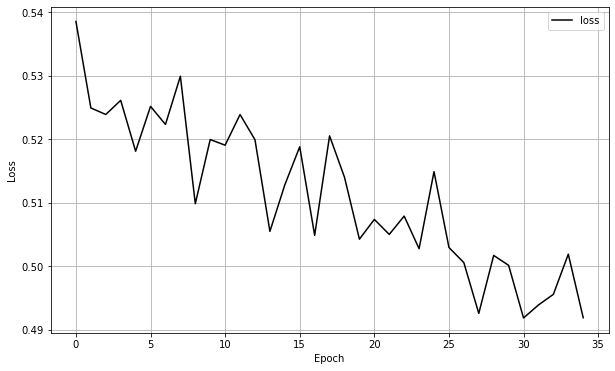

In [136]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'],color='black')
# plt.title('model_resnet50 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss'], loc='upper right')
plt.grid()
# plt.savefig('resnet50.png', dpi=480, bbox_inches='tight')
plt.show()

# Inference Pipeline

In [111]:
def sort_poly(p):
    min_axis = np.argmin(np.sum(p, axis=1))
    p = p[[min_axis, (min_axis+1)%4, (min_axis+2)%4, (min_axis+3)%4]]
    if abs(p[0, 0] - p[1, 0]) > abs(p[0, 1] - p[1, 1]):
        return p
    else:
        return p[[0, 3, 2, 1]]

In [112]:
def intersection(g, p):
    g = Polygon(g[:8].reshape((4, 2)))
    p = Polygon(p[:8].reshape((4, 2)))
    if not g.is_valid or not p.is_valid:
        return 0
    inter = Polygon(g).intersection(Polygon(p)).area
    union = g.area + p.area - inter
    if union == 0:
        return 0
    else:
        return inter/union

In [113]:
def weighted_merge(g, p):
    g[:8] = (g[8] * g[:8] + p[8] * p[:8])/(g[8] + p[8])
    g[8] = (g[8] + p[8])
    return g

In [114]:
def standard_nms(S, thres):
    order = np.argsort(S[:, 8])[::-1]
    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        ovr = np.array([intersection(S[i], S[t]) for t in order[1:]])

        inds = np.where(ovr <= thres)[0]
        order = order[inds+1]

    return S[keep]

In [115]:
def nms_locality(polys, thres=0.3):
    '''
    :param polys: a N*9 numpy array. first 8 coordinates, then prob
    :return: boxes after nms
    '''
    S = []
    p = None
  
    for g in polys:
        if p is not None and intersection(g, p) > thres:
        
            p = weighted_merge(g, p)
        else:
            if p is not None:
                S.append(p)
            p = g
  
    if p is not None:
        S.append(p)

    if len(S) == 0:
        return np.array([])
    
    return standard_nms(np.array(S), thres)

In [116]:
# Inference pipeline function used for generating predicted bounding boxes on image for text detection
def inferencePipeline(img):
    start_time=time.time()
      #Text Detection
    img=cv2.resize(img,(512,512))
    ii=model.predict(np.expand_dims(img,axis=0))
    score_map=ii[0][:,:,0]
    geo_map=ii[0][:,:,1:]

    for ind in [0,1,2,3,4]:
        geo_map[:,:,ind]*=score_map
    #ROI Rotate  
    score_map_thresh=0.5
    box_thresh=0.1 
    nms_thres=0.2
    if len(score_map.shape) == 4:
        score_map = score_map[0, :, :, 0]
        geo_map = geo_map[0, :, :, :]
    #filter the score map
    xy_text = np.argwhere(score_map > score_map_thresh)
    # sort the text boxes via the y axis
    xy_text = xy_text[np.argsort(xy_text[:, 0])]
    # restore
    text_box_restored = restore_rectangle(xy_text[:, ::-1], geo_map[xy_text[:, 0], xy_text[:, 1], :]) # N*4*2
    boxes = np.zeros((text_box_restored.shape[0], 9), dtype=np.float32)
    boxes[:, :8] = text_box_restored.reshape((-1, 8))
    boxes[:, 8] = score_map[xy_text[:, 0], xy_text[:, 1]]
    boxes = nms_locality(boxes.astype(np.float64), nms_thres)
    # here we filter some low score boxes by the average score map, this is different from the orginal paper
    for i, box in enumerate(boxes):
        mask = np.zeros_like(score_map, dtype=np.uint8)
        cv2.fillPoly(mask, box[:8].reshape((-1, 4, 2)).astype(np.int32), 1)
        boxes[i, 8] = cv2.mean(score_map, mask)[0]
        if i==4:
            break
    if len(boxes)>0:
        boxes = boxes[boxes[:, 8] > box_thresh]
    boxes[:,:8:2] = np.clip(boxes[:,:8:2], 0, 512 - 1)
    boxes[:,1:8:2] = np.clip(boxes[:,1:8:2], 0, 512 - 1)  
    res = []
    result = []
    if len(boxes)>0:
        for box in boxes:
            box_ =  box[:8].reshape((4, 2))
            if np.linalg.norm(box_[0] - box_[1]) < 8 or np.linalg.norm(box_[3]-box_[0]) < 8:
                continue
            result.append(box_)
    res.append(np.array(result, np.float32))   

    box_index = []
    brotateParas = []
    filter_bsharedFeatures = []
    for i in range(len(res)):
        rotateParas = []
        rboxes=res[i]
        txt=[]
        for j, rbox in enumerate(rboxes):
            para = restore_roiRotatePara(rbox)
            if para and min(para[1][2:]) > 8:
                rotateParas.append(para)
                box_index.append((i, j))
        pts=[]   
  #Text Recognition (From boxes given by Text Detection+ROI Rotate) 
    if len(rotateParas) > 0:
        for num in range(len(rotateParas)):
            text=""
            out=rotateParas[num][0]
            crop=rotateParas[num][1]
            points=np.array([[out[0],out[1]],[out[0]+out[2],out[1]],[out[0]+out[2],out[1]+out[3]],[out[0],out[1]+out[3]]])
            pts.append(points)
  #Labeling detected and Recognized Text in Image
    
    for i in range(len(pts)):
        cv2.polylines(img,[pts[i]],isClosed=True,color=(0,255,0),thickness=2)
    end_time=time.time()
    print("Time Taken By Pipeline="+str(end_time-start_time)+" seconds") 
    return img   


1/1 [==============================] - 0s 374ms/step
Time Taken By Pipeline=0.6244299411773682 seconds


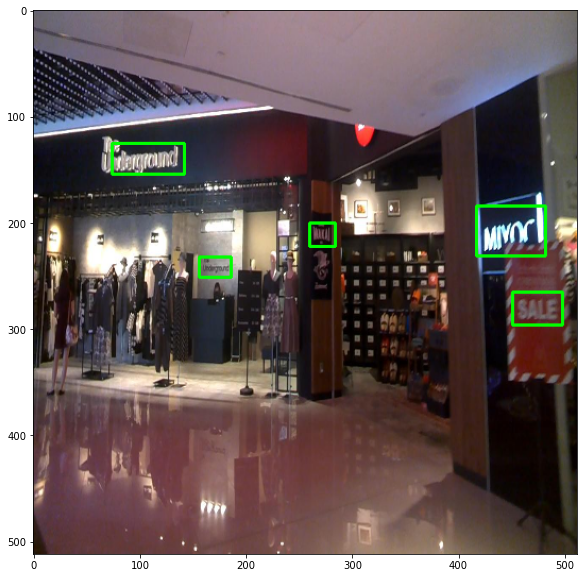

In [139]:
img=cv2.imread('/home/cloudcraftz/subhasish/RBOX Geometry/ICDAR_2015/test/img_428.jpg')
# img = cv2.imread('/home/cloudcraftz/subhasish/RBOX Geometry/1.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
im=inferencePipeline(img)
plt.figure(figsize=(10,10))
plt.imshow(im)

In [ ]:
train_data['images'][48]
train_data=train_data.drop(48)
train_data.shape

In [ ]:
#Computing losses for each and every datapoint

losses=[]
for i in range(len(train_data)):
    input_size=512
    if i == 48:
        continue
    filepath = train_data['images'][i]
    gt_file = train_data['ground_truth'][i]
    try: 
        if filepath == dir_path+'train/img_141.jpg':
            continue
        img_p = cv2.imread(filepath) 
        img_p = cv2.resize(img_p,(512,512))
        y_pred = model.predict(np.expand_dims(img_p,axis=0))
        y_pred_cls=y_pred[:,:,:,0]
        y_pred_geo=y_pred[:,:,:,1:6]
        im = cv2.imread(filepath,cv2.IMREAD_UNCHANGED)
        h, w, _ = im.shape
        text_polys, text_tags = load_annoataion(gt_file)
        text_polys, text_tags = check_and_validate_polys(text_polys, text_tags, (h, w))
        new_h, new_w, _ = im.shape
        resize_h = input_size
        resize_w = input_size
        im = cv2.resize(im, dsize=(512, 512),interpolation = cv2.INTER_AREA)
        resize_ratio_3_x = resize_w/float(new_w)
        resize_ratio_3_y = resize_h/float(new_h)
        text_polys[:, :, 0] *= resize_ratio_3_x
        text_polys[:, :, 1] *= resize_ratio_3_y
        new_h, new_w, _ = im.shape
        y_true_cls, y_true_geo, training_mask, rbox, text_tags, recg_mask = generate_rbox((new_h, new_w), text_polys, text_tags)
        y_true_cls1=y_true_cls/1.0
        training_mask1=training_mask/1.0
        y_true_cls1=y_true_cls1.astype('float32')
        training_mask1=training_mask.astype('float32')

        dice_loss = dice_coefficient(y_true_cls1, y_pred_cls, training_mask1)
        dice_loss =0.01*dice_loss

        y_true_geo1 = tf.reshape(y_true_geo,shape=(1,512,512,5))
        rbox_loss_ = rbox_loss(y_true_cls,y_true_geo1,y_pred_geo,training_mask)
        loss = 100*(rbox_loss_ + dice_loss).numpy()
        losses.append(loss)
    except Exception as e:
        print(e)
            

In [ ]:
#train_data['loss'] = losses

In [ ]:
#train_data.to_csv('train_data_losses.csv', index = None )

In [ ]:
#Computing losses for each and every datapoint  ##  test data
losses_test=[]
for i in range(len(test_data)):
    input_size=512
    filepath = test_data['images'][i]
    gt_file = test_data['ground_truth'][i]
    img_p = cv2.imread(filepath) 
    img_p = cv2.resize(img_p,(512,512))
    y_pred = model.predict(np.expand_dims(img_p,axis=0))
    y_pred_cls=y_pred[:,:,:,0]
    y_pred_geo=y_pred[:,:,:,1:6]
    im = cv2.imread(filepath,cv2.IMREAD_UNCHANGED)
    h, w, _ = im.shape
    text_polys, text_tags = load_annoataion(gt_file)
    text_polys, text_tags = check_and_validate_polys(text_polys, text_tags, (h, w))
    new_h, new_w, _ = im.shape
    resize_h = input_size
    resize_w = input_size
    im = cv2.resize(im, dsize=(512, 512),interpolation = cv2.INTER_AREA)
    resize_ratio_3_x = resize_w/float(new_w)
    resize_ratio_3_y = resize_h/float(new_h)
    text_polys[:, :, 0] *= resize_ratio_3_x
    text_polys[:, :, 1] *= resize_ratio_3_y
    new_h, new_w, _ = im.shape
    y_true_cls, y_true_geo, training_mask, rbox, text_tags, recg_mask = generate_rbox((new_h, new_w), text_polys, text_tags)
    y_true_cls1=y_true_cls/1.0
    training_mask1=training_mask/1.0
    y_true_cls1=y_true_cls1.astype('float32')
    training_mask1=training_mask.astype('float32')

    dice_loss = dice_coefficient(y_true_cls1, y_pred_cls, training_mask1)
    dice_loss =0.01*dice_loss

    y_true_geo1 = tf.reshape(y_true_geo,shape=(1,512,512,5))
    rbox_loss_ = rbox_loss(y_true_cls,y_true_geo1,y_pred_geo,training_mask)
    loss = 100*(rbox_loss_ + dice_loss).numpy()
    losses_test.append(loss)

In [ ]:
test_data['loss'] = losses_test

In [ ]:
test_data.to_csv('test_data_losses.csv', index = True)

In [ ]:
test_data.head(5)

In [ ]:
train_data.head(5)

In [ ]:
def bounding_box(img_array,df_txt,df_co):
    txt=np.array(df_txt)

    v = []
    for i in df_co:
        v.append(list(map(int,i)))

    b=np.array(v)
    (r, c) = b.shape

    for y in range(0, r):
        for x in range(0, c):
            rec_pts = np.array([[b[y,0],b[y,1]],[b[y,2],b[y,3]],[b[y,4],b[y,5]],[b[y,6],b[y,7]]], np.int32) ## taking the co ordinates of rectangle
            #rec_pts = pts.reshape((-1,1,2))
            img = cv2.polylines(img_array,[rec_pts],True,(0,255,255),thickness =2) ## used to draw bounding box on the image
      
            (text_width, text_height) = cv2.getTextSize(txt[y], cv2.FONT_HERSHEY_PLAIN, 1.5, 1)[0] ## taking width and height of the image
            # set the text start position
            text_offset_x = b[y,0] 
            text_offset_y = b[y,1] + 2
            # make the coords of the box with a small padding of two pixels
            box_coords = ((text_offset_x, text_offset_y), (text_offset_x + text_width + 2, text_offset_y - text_height - 2))
            #cv2.rectangle(img, box_coords[0], box_coords[1], (255, 255, 255), cv2.FILLED)
            #cv2.putText(img, txt[y], (text_offset_x, text_offset_y), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 1) ## put the text on the image
    plt.grid(False)      
    plt.imshow(img)

In [ ]:
import pytesseract
from spellchecker import SpellChecker
def final(img, model):
  spell = SpellChecker()
  #Configuration setting to convert image to string.  
  configuration = ("-l eng --oem 3 --psm 12")
  img = cv2.imread(filepath) 

  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  #1.Text Detection
  img=cv2.resize(img,(512,512))
  ii=model.predict(np.expand_dims(img,axis=0))
  score_map=ii[0][:,:,0]
  geo_map=ii[0][:,:,1:]
  print("Shape of Score Map",score_map.shape)
  print("Shape of Geo Map",geo_map.shape)

  for ind in [0,1,2,3,4]:
    geo_map[:,:,ind]*=score_map

  #2.ROI Rotate  
  score_map_thresh=0.5
  box_thresh=0.1 
  nms_thres=0.2
  if len(score_map.shape) == 4:
    score_map = score_map[0, :, :, 0]
    geo_map = geo_map[0, :, :, :]

  # filter the score map
  xy_text = np.argwhere(score_map > score_map_thresh)

  # sort the text boxes via the y axis
  xy_text = xy_text[np.argsort(xy_text[:, 0])]

  # restore
  text_box_restored = restore_rectangle(xy_text[:, ::-1], geo_map[xy_text[:, 0], xy_text[:, 1], :]) # N*4*2
  boxes = np.zeros((text_box_restored.shape[0], 9), dtype=np.float32)
  boxes[:, :8] = text_box_restored.reshape((-1, 8))
  boxes[:, 8] = score_map[xy_text[:, 0], xy_text[:, 1]]
  print("Boxes Shape",boxes.shape)
  boxes = nms_locality(boxes.astype(np.float64), nms_thres)


  # here we filter some low score boxes by the average score map, this is different from the orginal paper
  for i, box in enumerate(boxes):
    mask = np.zeros_like(score_map, dtype=np.uint8)
    cv2.fillPoly(mask, box[:8].reshape((-1, 4, 2)).astype(np.int32), 1)
    boxes[i, 8] = cv2.mean(score_map, mask)[0]

    if i==4:
      break
  if len(boxes)>0:
    boxes = boxes[boxes[:, 8] > box_thresh]
  boxes[:,:8:2] = np.clip(boxes[:,:8:2], 0, 512 - 1)
  boxes[:,1:8:2] = np.clip(boxes[:,1:8:2], 0, 512 - 1)  
  res = []
  result = []
  if len(boxes)>0:

    for box in boxes:
      box_ =  box[:8].reshape((4, 2))
      if np.linalg.norm(box_[0] - box_[1]) < 8 or np.linalg.norm(box_[3]-box_[0]) < 8:
        continue
      result.append(box_)
  res.append(np.array(result, np.float32))   

  box_index = []
  brotateParas = []
  filter_bsharedFeatures = []
  for i in range(len(res)):
    rotateParas = []
    rboxes=res[i]
    txt=[]
    for j, rbox in enumerate(rboxes):
      para = restore_roiRotatePara(rbox)
      if para and min(para[1][2:]) > 8:
        rotateParas.append(para)
        box_index.append((i, j))
    pts=[]   
    
    
    #3. Text Recognition (From boxes given by Text Detection+ROI Rotate) 
  txt = [] 
  if len(rotateParas) > 0:
      for num in range(len(rotateParas)):
        text=""
        out=rotateParas[num][0]
        crop=rotateParas[num][1]
        points=np.array([[out[0],out[1]],[out[0]+out[2],out[1]],[out[0]+out[2],out[1]+out[3]],[out[0],out[1]+out[3]]])
        angle=rotateParas[num][2] 
        img1=tf.image.crop_to_bounding_box(img,out[1],out[0],out[3],out[2])
        img2=tf.keras.preprocessing.image.random_rotation(img1,angle)
        img2=tf.image.crop_to_bounding_box(img2,crop[1],crop[0],crop[3],crop[2]).numpy()
        img2=cv2.resize(img2,(128,64))
        img2=cv2.detailEnhance(img2)
        plt.show()
        text = pytesseract.image_to_string(img2, config=configuration).strip()
        strn = spell.correction(text)
        strn = re.sub(r"\n", " ",strn)
        strn = re.sub(r"\t", " ", strn)
        strn = re.sub(r'[?|$|.|!]',r'',strn)
        strn = re.sub(r'[^a-zA-Z0-9 ]',r'',strn)
        txt.append(strn)
  
        pts.append(points)

  for i in range(len(txt)):
    cv2.polylines(img,[pts[i]],isClosed=True,color=(255,255,0),thickness=2)
   # cv2.putText(img,txt[i],(pts[i][0][0],pts[i][0][1]),cv2.FONT_HERSHEY_SIMPLEX,0.8, (0, 0, 255), 3)

  return img,txt

In [ ]:
for i in range(90,95):
    plt.figure(figsize = (20,10), dpi = 100)
    # Reading image from folder where it is stored 
    filepath = test_data['images'][i]
    txt_ = test_data['texts'][i]
    co_d = test_data['coordinates'][i]

    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_= img.copy()
    img=cv2.resize(img,(512,512))
  
    im,txt= final(img,model)
    print("Actual Texts:",txt_)
    print("Predicted texts:",txt)
    plt.figure(figsize=(16,6))
    # Plotting of source and destination image 
    plt.subplot(121),plt.title('Original',fontsize=15,color='dimgrey'), bounding_box(img_,txt_,co_d)
    plt.subplot(122),plt.title('Predicted',fontsize =15,color='dimgrey'), plt.imshow(im) 
    plt.show()
    print("="*100)

In [ ]:
from PIL import Image
filename = '/home/cvpr/Shared Tasks/Subhasish/test2.jpg'
img1 = np.array(Image.open(filename))
text = pytesseract.image_to_string(img1)

In [ ]:
print(text)

In [ ]:
new_model = tf.keras.models.load_model("/Users/subhasish/Documents/ISI_CVPR_BACKUP/scene_text_resnet50_50epochs.h5")